In [2]:
# Ignore warning
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import glob, os
import matplotlib.pyplot as plt
import numpy as np
import geopandas
import shapefile
import netCDF4
import h5py
import datetime as dt
import pyproj

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.layers.convolutional import Conv3D
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from tqdm import tqdm

from pyproj import Proj, transform
from shapely.geometry import Polygon
import cartopy.crs as ccrs

from scipy.interpolate import griddata
import metpy.calc as mpcalc
from metpy.units import units

import cdsapi
import xarray as xr
from urllib.request import urlopen

import pickle

Num GPUs Available:  0


In [3]:
def get_ice_motion(ncfile, i, sampling_size = 1):
# ncfile: input monthly ERA5 file (ncfile)
# field: input variable ('sst', 't2m', 'u10', 'v10')
# bounding_box: processed area (Ross Sea - Amundsen Sea)
# latlon_ib: geocoordinates of the iceberg (lat, lon)
# time_ib: date of the iceberg (datetime format)

    nc = netCDF4.Dataset(ncfile, 'r')
    keys = nc.variables.keys()
    fields = ['u', 'v']

    xs = np.array(nc.variables['x'])[::sampling_size]
    ys = np.array(nc.variables['y'])[::sampling_size]  
    xx, yy = np.meshgrid(xs, ys)
    lat = np.array(nc.variables['latitude'])[::sampling_size, ::sampling_size]
    lon = np.array(nc.variables['longitude'])[::sampling_size, ::sampling_size]

    days = np.array(nc.variables['time']).astype(float)

    for field in fields:                

        data2 = []       

        data = np.array(nc.variables[field][i][::sampling_size, ::sampling_size])
        # cm/s to km/day
        data[data == -9999] = np.nan
        data2.append(data*(3600*24/100000))                        

        data2 = np.array(data2) 
        data_mean = np.array([np.mean(data2, axis = 0)])

        # df[field] = data_mean.flatten()

        if field == "u":
            u = data2 # data_mean
            # u[np.isnan(u)] = 0
        elif field == "v":
            v = data2 # data_mean
            # v[np.isnan(v)] = 0
    
    nc.close()
    
    return xx, yy, lat, lon, u, v


def get_SIC(t1, xx, yy):
    ## Read SIC data ==================================================
    h5file = "../data/SIC/AMSR_U2_L3_SeaIce25km_B04_{0}.he5".format(dt.datetime.strftime(t1, "%Y%m%d"))
    
    if os.path.exists(h5file):
        f = h5py.File(h5file)

        lat2 = f['HDFEOS']['GRIDS']['NpPolarGrid25km']['lat'][:]
        lon2 = f['HDFEOS']['GRIDS']['NpPolarGrid25km']['lon'][:]
        sic = f['/HDFEOS/GRIDS/NpPolarGrid25km/Data Fields/SI_25km_NH_ICECON_DAY'][:].astype(float)
        sic[sic <= 0] = 0
        sic[sic > 100] = 0

        # EPSG:4326 (WGS84); EPSG:3408 (NSIDC EASE-Grid North - Polar pathfinder sea ice movement)
        # ESPG:3411 (NSIDC Sea Ice Polar Stereographic North - SIC data)
        inProj = Proj('epsg:4326')  
        outProj = Proj('epsg:3408')
        xx2,yy2 = transform(inProj,outProj,lat2,lon2)
        grid_sic = griddata((xx2.flatten(), yy2.flatten()), sic.flatten(), (xx, yy), method='linear')
        grid_sic[np.isnan(grid_sic)] = 0
        return grid_sic * 0.01  # Change into 0-1
    
    else:
        print("Filename is NOT correct!")

def retrieve_ERA5(year):
    c = cdsapi.Client()
    # dataset to read
    dataset = 'reanalysis-era5-single-levels'
    # flag to download data
    download_flag = False
    # api parameters 
    params = {
        'format': 'netcdf',
        'product_type': 'reanalysis',
        'variable': ['10m_u_component_of_wind', '10m_v_component_of_wind', '2m_temperature'],
        'year':[str(year)],
        'month': ['01', '02', '03', '04', '05', '06','07', '08', '09','10', '11', '12'],
        'day': ['01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
            '31',
               ],
        'area': [90, -180, 50,180],
        'time': ['12:00'],
        'grid': [1, 0.5],
        'area': [90, -180, 50, 180],
        }

    # retrieves the path to the file
    fl = c.retrieve(dataset, params)

    # load into memory
    with urlopen(fl.location) as f:
        ds = xr.open_dataset(f.read())

    return ds

def rotate_vector(u, v, lon):
    angle = lon*np.pi/180 # rotation angle (radian)
    u2 = u*np.cos(angle) - v*np.sin(angle)
    v2 = u*np.sin(angle) + v*np.cos(angle)
    return u2, v2

def get_ERA5(ds, i, xx, yy):
    lat3, lon3 = np.meshgrid(ds.latitude, ds.longitude)
    inProj = Proj('epsg:4326')  
    outProj = Proj('epsg:3408')
    xx3,yy3 = transform(inProj,outProj,lat3,lon3)
    t2m = np.array(ds.t2m[i]).transpose()
    u10 = np.array(ds.u10[i]).transpose()
    v10 = np.array(ds.v10[i]).transpose()
    
    u10, v10 = rotate_vector(u10, v10, lon3)
    
    grid_t2m = griddata((xx3.flatten(), yy3.flatten()), np.array(t2m).flatten(), (xx, yy), method='linear')
    grid_u10 = griddata((xx3.flatten(), yy3.flatten()), np.array(u10).flatten(), (xx, yy), method='linear')
    grid_v10 = griddata((xx3.flatten(), yy3.flatten()), np.array(v10).flatten(), (xx, yy), method='linear')
    
    grid_t2m[np.isnan(grid_t2m)] = 0
    grid_u10[np.isnan(grid_u10)] = 0
    grid_v10[np.isnan(grid_v10)] = 0
    
    return grid_t2m, grid_u10, grid_v10

def make_dataset(year, n_samples, ds, w = 1, datatype = "cell"):
    # ncfile = glob.glob("F:\\2022_Ross\\ERA5\\icemotion_daily_sh_25km_{0}*.nc".format(year))[0]
    ncfile = "../data/Sea_ice_drift/icemotion_daily_nh_25km_{0}0101_{0}1231_v4.1.nc".format(year)
    nc = netCDF4.Dataset(ncfile, 'r')
    ## Adjust the number of training datasets ===========================
    days = np.array(nc.variables['time']).astype(float)[:]
    row, col = np.shape(np.array(nc.variables['latitude']))
    
    # Initialize grid input ==========================================
    grid_input = np.zeros([len(n_samples), row, col, 6])
    grid_output = np.zeros([len(n_samples), row, col, 3])
    
    first = True
    
    for i, idx in tqdm(enumerate(n_samples)):
        t1 = dt.datetime(1970, 1, 1) + dt.timedelta(days = days[idx])
        t2 = dt.datetime(1970, 1, 1) + dt.timedelta(days = days[idx]+1)  

        ## Read ice motion data ===========================================
        sampling_size = 1
        xx, yy, lat, lon, u, v = get_ice_motion(ncfile, idx, sampling_size)
        grid_u = np.mean(u, axis = 0)
        grid_v = np.mean(v, axis = 0)      

        ## Read SIC data ==================================================
        grid_sic = get_SIC(t1, xx, yy)

        ## Read ERA5 data =================================================
        grid_t2m, grid_u10, grid_v10 = get_ERA5(ds, idx, xx, yy)

        grid_input[i, :, :, 0] = grid_u / 50 + 0.5
        grid_input[i, :, :, 1] = grid_v / 50 + 0.5
        grid_input[i, :, :, 2] = grid_sic
        grid_input[i, :, :, 3] = (grid_t2m - 240)/(320 - 240) #Max temp = 320 K, Min temp = 240 K)
        grid_input[i, :, :, 4] = grid_u10 / 50 + 0.5
        grid_input[i, :, :, 5] = grid_v10 / 50 + 0.5

        _, _, _, _, u2, v2 = get_ice_motion(ncfile, idx+1, sampling_size)
        grid_u2 = np.mean(u2, axis = 0)
        grid_v2 = np.mean(v2, axis = 0) 
        grid_output[i, :, :, 0] = grid_u2 / 50 + 0.5
        grid_output[i, :, :, 1] = grid_v2 / 50 + 0.5
        grid_sic2 = get_SIC(t2, xx, yy)
        grid_output[i, :, :, 2] = grid_sic2
        
        # Masking ======================================
        mask1 = (np.isnan(grid_u))
        mask2 = (np.isnan(grid_u2))

        if datatype == "cell":
            xx1, yy1 = [], []
            for m in range(w, row-w):
                for n in range(w, col-w):
                    ip = np.array([grid_input[i, m-w:m+w+1, n-w:n+w+1, :]])
                    if mask1[m,n] == False: #np.prod(ip[0, :, :, 2]) > 0:
                        op = np.array([grid_output[i, m-w:m+w+1, n-w:n+w+1, :]])
                        xx1.append(xx[m, n])
                        yy1.append(yy[m, n])
                        if first:
                            conv_input = ip
                            conv_output = op
                            first = False
                        else:
                            conv_input = np.concatenate((conv_input, ip), axis = 0)
                            conv_output = np.concatenate((conv_output, op), axis = 0)            

        elif datatype == "entire":
            var_ip = np.shape(grid_input)[3]
            var_op = np.shape(grid_output)[3]
            
            conv_input = np.copy(grid_input)
            conv_output = np.copy(grid_output)
            
            for m in range(0, var_ip):
                subset = grid_input[i, :, :, m]
                subset[mask1] = 0
                conv_input[i, :, :, m] = subset
                
            for n in range(0, var_op):
                subset = grid_output[i, :, :, n]
                subset[mask2] = 0
                conv_output[i, :, :, n] = subset
                
            xx1, yy1 = xx, yy

        elif datatype == "table":
            
            xx1, yy1 = [], []
            for m in range(w, row-w):
                for n in range(w, col-w):
                    ip = np.array([grid_input[i, m-w:m+w+1, n-w:n+w+1, :].flatten()])
                    if np.prod(grid_sic[m-w:m+w+1, n-w:n+w+1]) > 0:
                        op = np.array([grid_output[i, m-w:m+w+1, n-w:n+w+1, :].flatten()])
                        xx1.append(xx[m, n])
                        yy1.append(yy[m, n])
                        
                        if first:
                            conv_input = ip
                            conv_output = op
                            first = False
                        else:
                            conv_input = np.concatenate((conv_input, ip), axis = 0)
                            conv_output = np.concatenate((conv_output, op), axis = 0)  

    return xx1, yy1, conv_input, conv_output

def MAE(obs, prd):
    return np.nanmean(abs(obs-prd))

### Read sea ice drift data

In [16]:
### INPUT AS A 3x3 CELL

## Read sea ice movement
try:
    nc.close()
except:
    pass

year = 2021
months = np.arange(1,13)
first = True

# ERA5 yearly data
if 'ds' not in locals():
    ds = retrieve_ERA5(year)

for datatype in ["entire"]:
    for month in months:
        d1 = int(dt.datetime(year, month, 1).strftime('%j')) - 1
        if month == 12:
            d2 = int(dt.datetime(year, 12, 31).strftime('%j')) - 1
        else:
            d2 = int(dt.datetime(year, month+1, 1).strftime('%j')) - 1
            
        n_samples = np.arange(d1, d2, 1)
        xx, yy, train_input, train_output = make_dataset(year, n_samples, ds, datatype = datatype)
        train_save = [xx, yy, train_input, train_output]

        # Open a file and use dump()
        with open('../data/train_{0}_{1}.pkl'.format(datatype, dt.datetime(year, month, 1).strftime('%Y%m')), 'wb') as file:
            # A new file will be created
            pickle.dump(train_save, file)

        print(dt.datetime(year, month, 1).strftime('%Y%m'))

2023-06-30 17:39:04,589 INFO Welcome to the CDS
2023-06-30 17:39:04,589 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-06-30 17:39:05,026 INFO Request is completed
31it [01:54,  3.70s/it]


202101


28it [01:45,  3.78s/it]


202102


31it [01:50,  3.57s/it]


202103


30it [01:46,  3.54s/it]


202104


31it [01:56,  3.74s/it]


202105


30it [02:01,  4.04s/it]


202106


31it [01:58,  3.83s/it]


202107


31it [01:54,  3.70s/it]


202108


30it [01:51,  3.72s/it]


202109


31it [01:54,  3.71s/it]


202110


30it [01:57,  3.90s/it]


202111


30it [01:45,  3.51s/it]


202112


In [22]:
## Test dataset
first = True

for datatype in ["entire"]:
    n_samples = np.arange(5,10,10)
    
    xx, yy, test_input, test_output = make_dataset(year, n_samples, ds, datatype = datatype)
    # xx, yy, conv_input, conv_output = make_dataset(year, i, ds)

    # if first:
    #     test_input = conv_input
    #     test_output = conv_output
    #     first = False
    # else:
    #     test_input = np.concatenate((train_input, conv_input), axis = 0)
    #     test_output = np.concatenate((train_output, conv_output), axis = 0)
        
    test_save = [xx, yy, test_input, test_output]

    # Open a file and use dump()
    with open('../data/test_{0}_{1}.pkl'.format(datatype, len(n_samples)), 'wb') as file:
        # A new file will be created
        pickle.dump(test_save, file)

    print("Complete creating test data")

1it [00:03,  4.00s/it]

Complete creating test data


In [4]:
class custom_loss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, obs, prd):
        # err_u = tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 0]-prd[:, 1, 1, 0])**2)) / tf.reduce_mean(tf.abs(obs[:, 1, 1, 0]))
        # err_v = tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 1]-prd[:, 1, 1, 1])**2)) / tf.reduce_mean(tf.abs(obs[:, 1, 1, 1]))
        # err_sic = tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 2]-prd[:, 1, 1, 2])**2)) / tf.reduce_mean(obs[:, 1, 1, 2]) * 0.01
        err_u = (obs[:, :, :, 0]-prd[:, :, :, 0])**2
        err_v = (obs[:, :, :, 1]-prd[:, :, :, 1])**2
        err_sic = tf.abs(obs[:, :, :, 2]-prd[:, :, :, 2])
        
        err_sum = tf.sqrt(tf.reduce_mean(err_u*err_sic)) + tf.sqrt(tf.reduce_mean(err_v*err_sic))
        return err_sum
    
class physics_loss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, obs, prd):
        # err_u = tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 0]-prd[:, 1, 1, 0])**2)) / tf.reduce_mean(tf.abs(obs[:, 1, 1, 0]))
        # err_v = tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 1]-prd[:, 1, 1, 1])**2)) / tf.reduce_mean(tf.abs(obs[:, 1, 1, 1]))
        # err_sic = tf.sqrt(tf.reduce_mean((obs[:, 1, 1, 2]-prd[:, 1, 1, 2])**2)) / tf.reduce_mean(obs[:, 1, 1, 2]) * 0.01
        
        # Physical loss term
        u = prd[:, :, :, 0]
        v = prd[:, :, :, 1]
        
        # Divergence of sea ice drift
        div = (u[1,2]-u[1,0]) + (v[2,1]-v[0,1])
        # div = mpcalc.divergence(u, v, dx = 25 * units('km'), dy = 25 * units('km'))
        div_mean = tf.reduce_mean(div)
        div_std = tf.math.reduce_std(div)
        
        # SIC change
        d_sic = tf.reduce_mean(prd[:, :, :, 2] - obs[:, :, :, 2])
        err_phy = tf.maximum(tf.cast(tf.abs(div_mean)-div_std > 0, tf.float32) * div_mean/tf.abs(div_mean) * d_sic, 0)        

        ## Data loss term
        err_u = (obs[:, :, :, 0]-prd[:, :, :, 0])**2
        err_v = (obs[:, :, :, 1]-prd[:, :, :, 1])**2
        err_sic = tf.abs(obs[:, :, :, 2]-prd[:, :, :, 2])
        
        w = tf.constant(2.0)
        
        err_sum = tf.sqrt(tf.reduce_mean(err_u*err_sic)) + tf.sqrt(tf.reduce_mean(err_v*err_sic)) + w*err_phy
        return err_sum

In [65]:
with open('../data/train_cell_5.pkl', 'rb') as file:
    xx, yy, train_input, train_output = pickle.load(file)
    
with open('../data/test_cell_1.pkl', 'rb') as file:
    xx, yy, test_input, test_output = pickle.load(file)

    
## Normal CNN (without physical loss)
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding = "same", activation='linear', input_shape=np.shape(train_input)[1:]))
# model.add(layers.Conv2D(32, (3, 3), padding = "same", activation='linear'))
# model.add(layers.Conv2D(16, (3, 3), padding = "same", activation='linear'))
# model.add(layers.Conv2D(8, (3, 3), padding = "same", activation='linear'))
model.add(layers.Conv2D(3, (3, 3), padding = "same", activation='linear'))

# model = models.Sequential([
#     tf.keras.layers.Flatten(input_shape=np.shape(train_input)[1:]),
#     tf.keras.layers.Dense(54, activation='relu'),
#     tf.keras.layers.Dense(3)
# ])
# model.add(layers.Dense(32, activation='tanh'))
# model.add(layers.Dense(32, activation='tanh'))
# model.add(layers.Dense(3, activation='tanh'))
model.summary()

# tf.keras.Model(inputs, outputs, name="U-Net")
# unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
#                    loss="sparse_categorical_crossentropy",
#                    metrics="accuracy")

model.compile(optimizer='adam', loss=custom_loss())
model.fit(train_input, train_output, epochs=5, verbose = 1)


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 3, 3, 32)          1760      
                                                                 
 conv2d_19 (Conv2D)          (None, 3, 3, 3)           867       
                                                                 
Total params: 2,627
Trainable params: 2,627
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
2917/2917 [==============================] - 5s 1ms/step - loss: 0.0459
Epoch 2/5
2917/2917 [==============================] - 4s 1ms/step - loss: 0.0391
Epoch 3/5
2917/2917 [==============================] - 4s 1ms/step - loss: 0.0379
Epoch 4/5
2917/2917 [==============================] - 4s 1ms/step - loss: 0.0371
Epoch 5/5
2917/2917 [==============================] - 4s 1ms/step - loss: 0.0365


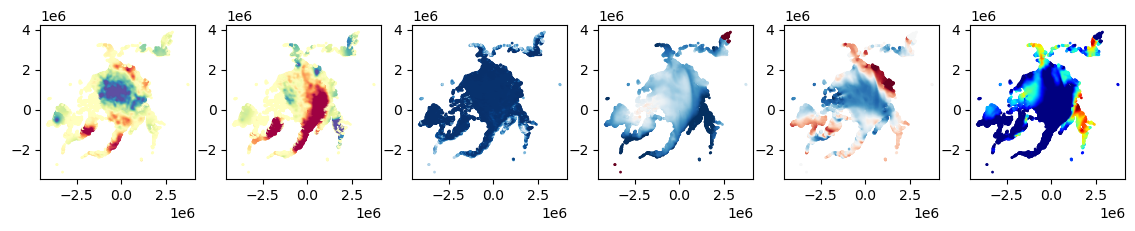

In [66]:
vmax = [10, 10, 100, 10, 10, 0.5]
vmin = [-10, -10, 0, -10, -10, 0]
scaling = [30, 30, 100, 30, 30, 1]
cm = ['Spectral', 'Spectral', 'Blues', 'RdBu', 'RdBu', 'jet']

fig, ax = plt.subplots(1, 6, figsize = (14,2))
for k in range(0, len(ax)):
    ax[k].scatter(xx, yy, c=test_input[:, 1, 1, k]*scaling[k], s=1, vmax = vmax[k], vmin = vmin[k], cmap = cm[k])
    # ax[2, k].scatter(xx, yy, c=test_output[:, 1, 1, k]*scaling[k], s=1, vmax = vmax[k], vmin = vmin[k], cmap = cm[k])

561/561 [==============================] - 0s 706us/step


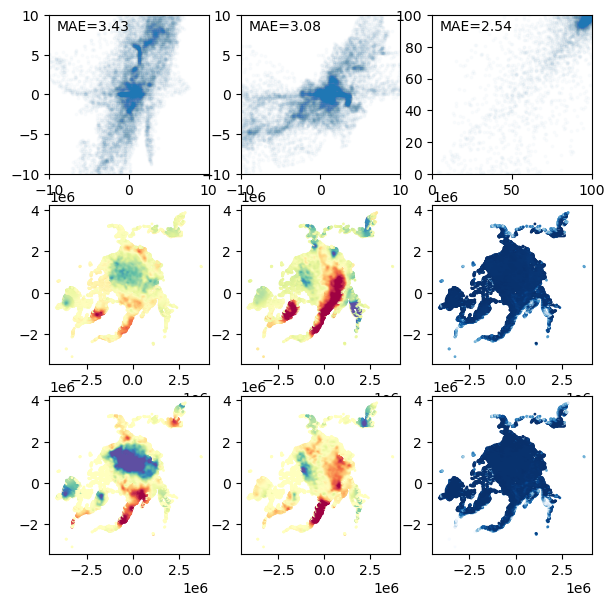

In [67]:
# Cell type visualization -------------------------------
pred = model.predict(test_input)

fig, ax = plt.subplots(3, 3, figsize = (7,7))

vmax = [10, 10, 100]
vmin = [-10, -10, 0]
scaling = [30, 30, 100]
cm = ['Spectral', 'Spectral', 'Blues']

for k in range(0, len(ax)):
    obs = test_output[:, 1, 1, k]*scaling[k]
    prd = pred[:, 1, 1, k]*scaling[k]
    ax[0, k].scatter(prd, obs,  s = 3, alpha = 0.02)
    ax[0, k].text(vmin[k] + (vmax[k]-vmin[k])*0.05, vmax[k] - (vmax[k]-vmin[k])*0.1, "MAE={0:.2f}".format(MAE(obs,prd)))
    ax[0, k].set_xlim(vmin[k], vmax[k])
    ax[0, k].set_ylim(vmin[k], vmax[k])
    # ax[0, k].scatter(, conv_output[:, 1, 1, k], s = 2, alpha = 0.01)
    
    ax[1, k].scatter(xx, yy, c=pred[:, 1, 1, k]*scaling[k], s=1, vmax = vmax[k], vmin = vmin[k], cmap = cm[k])
    ax[2, k].scatter(xx, yy, c=test_output[:, 1, 1, k]*scaling[k], s=1, vmax = vmax[k], vmin = vmin[k], cmap = cm[k])

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding = "same", activation='linear', input_shape=np.shape(train_input)[1:]))
# model.add(layers.Conv2D(32, (3, 3), padding = "same", activation='linear'))
# model.add(layers.Conv2D(16, (3, 3), padding = "same", activation='linear'))
# model.add(layers.Conv2D(8, (3, 3), padding = "same", activation='linear'))
model.add(layers.Conv2D(3, (3, 3), padding = "same", activation='linear'))

# model = models.Sequential([
#     tf.keras.layers.Flatten(input_shape=np.shape(train_input)[1:]),
#     tf.keras.layers.Dense(54, activation='relu'),
#     tf.keras.layers.Dense(3)
# ])
# model.add(layers.Dense(32, activation='tanh'))
# model.add(layers.Dense(32, activation='tanh'))
# model.add(layers.Dense(3, activation='tanh'))
model.summary()

# tf.keras.Model(inputs, outputs, name="U-Net")
# unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
#                    loss="sparse_categorical_crossentropy",
#                    metrics="accuracy")

model.compile(optimizer='adam', loss=physics_loss())
model.fit(train_input, train_output, epochs=5, verbose = 1)


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 3, 3, 32)          1760      
                                                                 
 conv2d_23 (Conv2D)          (None, 3, 3, 3)           867       
                                                                 
Total params: 2,627
Trainable params: 2,627
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
2917/2917 [==============================] - 5s 1ms/step - loss: 0.0798
Epoch 2/5
2917/2917 [==============================] - 4s 1ms/step - loss: 0.0589
Epoch 3/5
2917/2917 [==============================] - 4s 1ms/step - loss: 0.0554
Epoch 4/5
2917/2917 [==============================] - 4s 1ms/step - loss: 0.0532
Epoch 5/5
2917/2917 [==============================] - 4s 1ms/step - loss: 0.0535


561/561 [==============================] - 0s 729us/step


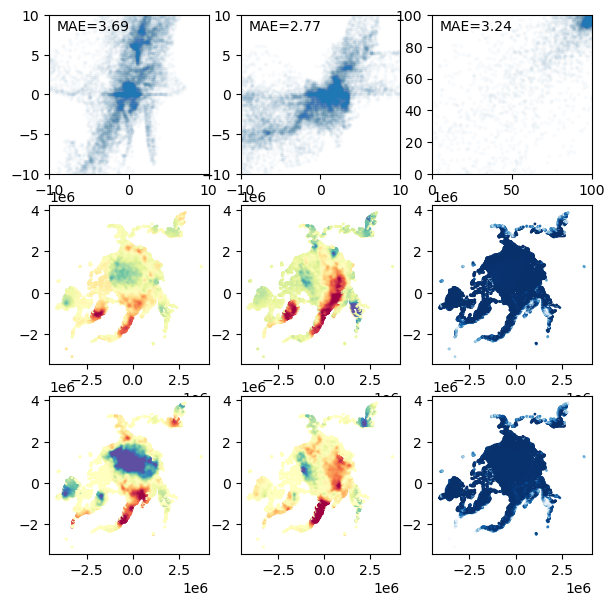

In [ ]:
# Cell type visualization -------------------------------
pred = model.predict(test_input)

fig, ax = plt.subplots(3, 3, figsize = (7,7))

vmax = [10., 10., 100.]
vmin = [-10., -10., 0.]
scaling = [30., 30., 100.]
cm = ['Spectral', 'Spectral', 'Blues']

for k in range(0, len(ax)):
    obs = test_output[:, 1, 1, k]*scaling[k]
    prd = pred[:, 1, 1, k]*scaling[k]
    ax[0, k].scatter(prd, obs,  s = 3, alpha = 0.02)
    ax[0, k].text(vmin[k] + (vmax[k]-vmin[k])*0.05, vmax[k] - (vmax[k]-vmin[k])*0.1, "MAE={0:.2f}".format(MAE(obs,prd)))
    ax[0, k].set_xlim(vmin[k], vmax[k])
    ax[0, k].set_ylim(vmin[k], vmax[k])
    # ax[0, k].scatter(, conv_output[:, 1, 1, k], s = 2, alpha = 0.01)
    
    ax[1, k].scatter(xx, yy, c=pred[:, 1, 1, k]*scaling[k], s=1, vmax = vmax[k], vmin = vmin[k], cmap = cm[k])
    ax[2, k].scatter(xx, yy, c=test_output[:, 1, 1, k]*scaling[k], s=1, vmax = vmax[k], vmin = vmin[k], cmap = cm[k])

In [26]:
np.shape(pred)

(1, 361, 361, 3)

In [32]:
pred[0, :, :, k]*scaling[k]

array([[ 6.9656024 ,  0.81510264,  1.454713  , ...,  1.454713  ,
         0.13878901, -0.8975933 ],
       [16.955044  ,  5.300949  ,  9.236865  , ...,  9.236865  ,
         9.647277  ,  0.5513682 ],
       [13.532174  ,  0.38569352,  4.4981546 , ...,  4.4981546 ,
         7.064226  , -1.7305121 ],
       ...,
       [13.532174  ,  0.38569352,  4.4981546 , ...,  4.4981546 ,
         7.064226  , -1.7305121 ],
       [22.11013   , 12.781179  , 17.415964  , ..., 17.415964  ,
        19.915138  ,  5.338277  ],
       [13.133991  ,  8.865224  , 11.339009  , ..., 11.339009  ,
        17.4142    ,  1.0690014 ]], dtype=float32)